## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [15]:
import sys
# !{sys.executable} -m pip install gdown h5py

In [16]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
# url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
# output = "IT_data.h5"
# gdown.download(url, output, quiet=False, fuzzy=True)


### Load the data

In [17]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [18]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


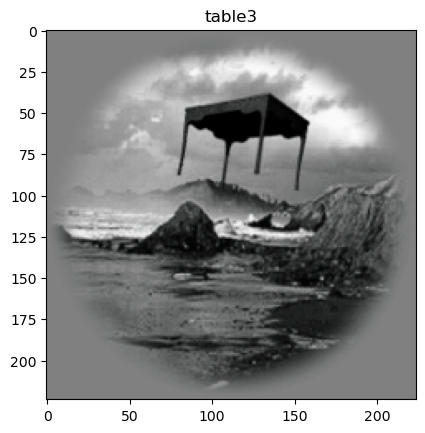

In [19]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

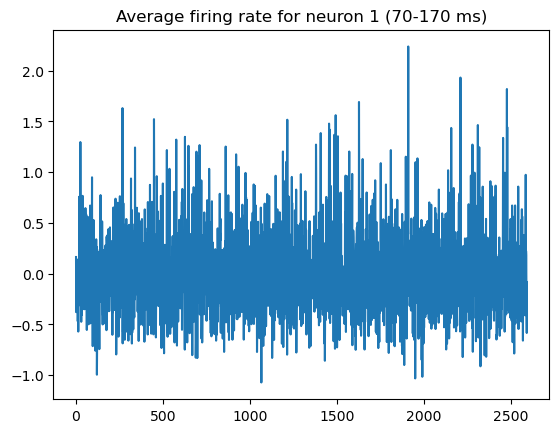

In [20]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

In [21]:
display(stimulus_train.shape)
display(spikes_train.shape)

(2592, 3, 224, 224)

(2592, 168)

**Each row = an image, each col is the avg activity (70-170 ms window after stimulis) of IT neuron i with i from 1 to 168**


In [22]:
import pandas as pd

# Flatten images for regression
X_flat_train = stimulus_train.reshape(stimulus_train.shape[0], -1)  # (N_train, 150528)
X_flat_val = stimulus_val.reshape(stimulus_val.shape[0], -1)  # (N_val, 150528) 

# Combine into DataFrame
df_train = pd.DataFrame({
    'image_index': range(len(stimulus_train)),
    'image': list(stimulus_train),
    'image_flat': list(X_flat_train),
    'spikes': list(spikes_train),
    'object_label': objects_train
})

df_val = pd.DataFrame({
    'image_index': range(len(stimulus_val)),
    'image': list(stimulus_val),
    'image_flat': list(X_flat_val),
    'spikes': list(spikes_val),
    'object_label': objects_val
})
df_train.head()

,image_index,image,image_flat,spikes,object_label
0,0,"[[[0.07406463, 0.07406463, 0.07406463, 0.07406...","[0.07406463, 0.07406463, 0.07406463, 0.0740646...","[0.015342401, 0.16385917, -0.07326181, 0.05025...",face6
1,1,"[[[0.07406463, 0.07406463, 0.07406463, 0.07406...","[0.07406463, 0.07406463, 0.07406463, 0.0740646...","[-0.098782785, -0.37968943, -0.2231606, -0.694...",table3
2,2,"[[[0.07406463, 0.07406463, 0.07406463, 0.07406...","[0.07406463, 0.07406463, 0.07406463, 0.0740646...","[-0.10554082, -0.011887464, 0.70853746, -0.186...",face3
3,3,"[[[0.07406463, 0.07406463, 0.07406463, 0.07406...","[0.07406463, 0.07406463, 0.07406463, 0.0740646...","[0.14249635, 0.09053583, 0.31253663, 8.732898e...",face2
4,4,"[[[0.07406463, 0.07406463, 0.07406463, 0.07406...","[0.07406463, 0.07406463, 0.07406463, 0.0740646...","[-0.38021672, 0.010980441, -0.4571454, 0.25994...",lioness


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


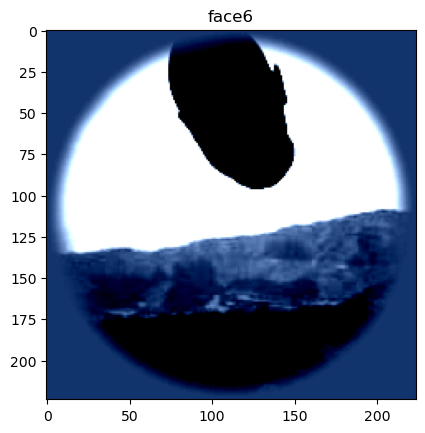

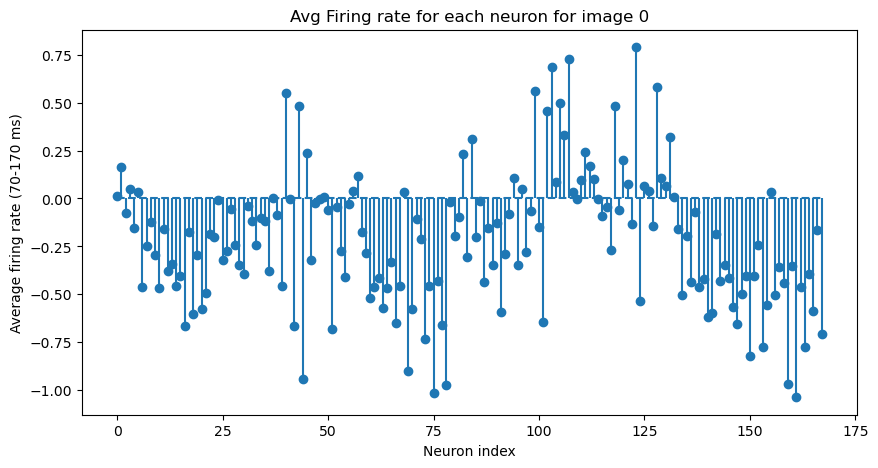

In [23]:

plt.imshow(np.transpose(df_train['image'][0], (1, 2, 0)))
plt.title(df_train["object_label"][0])
plt.show()
plt.figure(figsize=(10, 5))
# plt.scatter(y = df_train['spikes'][0],x = range(1,len(df_train["spikes"][0]) + 1))
plt.stem(df_train['spikes'][0], basefmt="--")
plt.xlabel('Neuron index')
plt.ylabel('Average firing rate (70-170 ms)')
plt.title('Avg Firing rate for each neuron for image 0')
plt.show()




<span style="color:orange">

**Negative freq ==> they substracted baseline activity (said in the paper) thus negative avg firing rate means that on avg activity decreased compared to baseline activity when image 0 was shown, i guess...**


## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

<span style="color:orange">

**Baseline linear model to predict the neural activity of each I neurons when presented to raw image.**

Input : 
- flatten images into 1D vectors 
- standardize the input data

Output : 
- average firing rates measured in the IT cortex between 70 and 170 ms after stimulus onset — one vector per image

Models:
- Linear Regression
- Ridge Regression


In [24]:
# LINEAR MODEL

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from tqdm import tqdm

# Flatten images
X_train = np.vstack(df_train['image_flat'].values)
X_val = np.vstack(df_val['image_flat'].values)

# Standardize pixel values (mean 0, std 1)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)

# Targets
Y_train = np.vstack(df_train['spikes'])
Y_val = np.vstack(df_val['spikes'])

# for quicker training ==> float 32
X_train_std = X_train_std.astype(np.float32)
X_val_std = X_val_std.astype(np.float32)
Y_train = Y_train.astype(np.float32)
Y_val = Y_val.astype(np.float32)


In [10]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=0.1, solver='auto'),
}

predictions = {}

for name in models:
    model = models[name]
    model.fit(X_train_std, Y_train)
    Y_pred = model.predict(X_val_std)
    predictions[name] = Y_pred
    print(f"{name} model trained and predicted")
print("Done")


LinearRegression model trained and predicted


c:\Users\mathi\.conda\envs\brain_like\lib\site-packages\sklearn\linear_model\_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=5.74699e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Ridge model trained and predicted
Done


##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

<span style="color:orange">

**Compute baseline linear model performances ==> explained Var and Pearson correlation**

Explained Variance (LinearRegression): -0.0374
Mean Pearson Correlation (LinearRegression): 0.2203


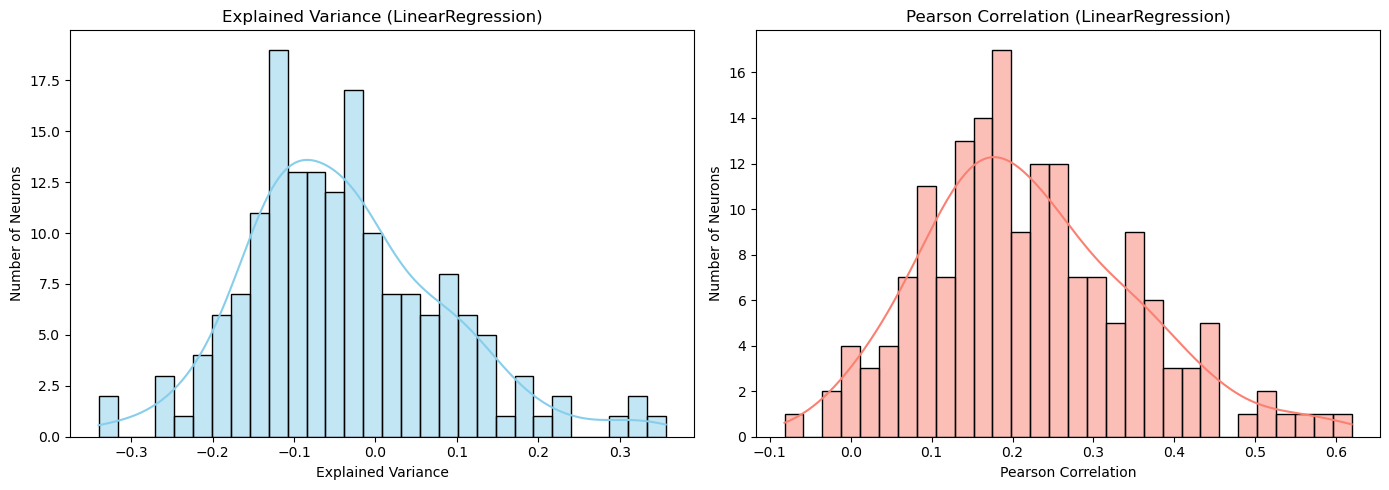

Explained Variance (Ridge): -0.9230
Mean Pearson Correlation (Ridge): 0.1638


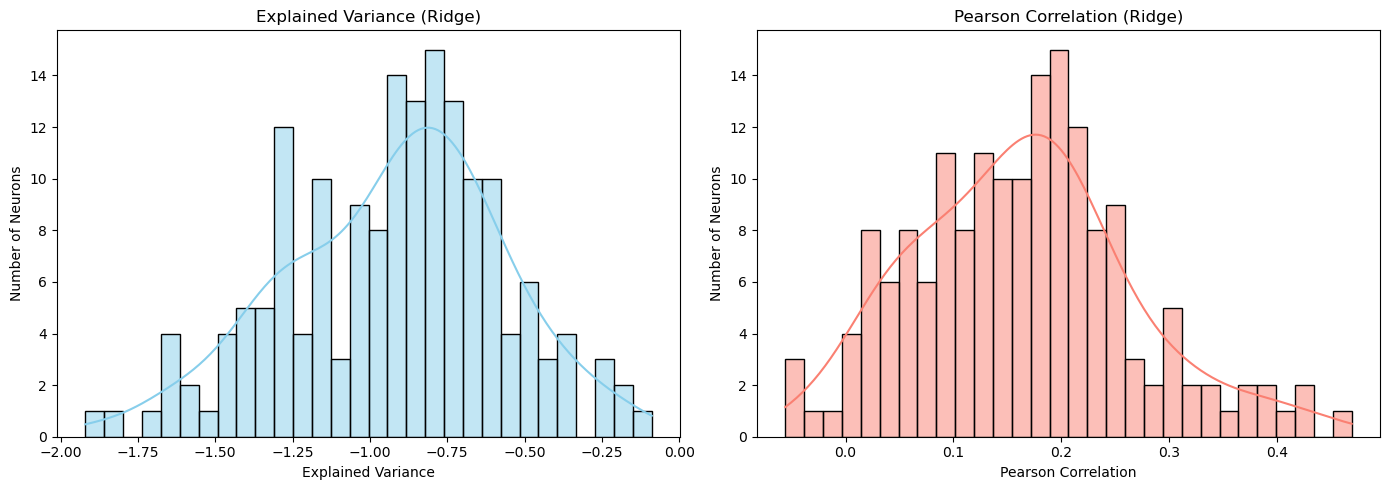

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import explained_variance_score


def compute_pearson_per_neuron(Y_true, Y_pred):
    return np.array([
        pearsonr(Y_true[:, i], Y_pred[:, i])[0] for i in range(Y_true.shape[1])
    ])


def plot_performance_metrics(Y_pred, model_name, Y_val=Y_val, verbose = True):
    explained_var = explained_variance_score(Y_val, Y_pred, multioutput='raw_values')
    corr_per_neuron = compute_pearson_per_neuron(Y_val, Y_pred)

    if verbose:
        print(f"Explained Variance ({model_name}): {explained_var.mean():.4f}")
        print(f"Mean Pearson Correlation ({model_name}): {corr_per_neuron.mean():.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Explained variance 
    sns.histplot(explained_var, bins=30, kde=True, color="skyblue", ax=axes[0])
    axes[0].set_title(f"Explained Variance ({model_name})")
    axes[0].set_xlabel("Explained Variance")
    axes[0].set_ylabel("Number of Neurons")

    # Pearson correlation
    sns.histplot(corr_per_neuron, bins=30, kde=True, color="salmon", ax=axes[1])
    axes[1].set_title(f"Pearson Correlation ({model_name})")
    axes[1].set_xlabel("Pearson Correlation")
    axes[1].set_ylabel("Number of Neurons")

    plt.tight_layout()
    plt.show()


for i, (Y_pred, model_name) in enumerate(zip(predictions.values(), predictions.keys())):
    plot_performance_metrics(Y_pred, model_name)

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

<span style="color:orange">

**Compute PCA keep the first 1000-PC rather than all the pixels**

Explained Variance (Ridge): -0.0704
Mean Pearson Correlation (Ridge): 0.2211


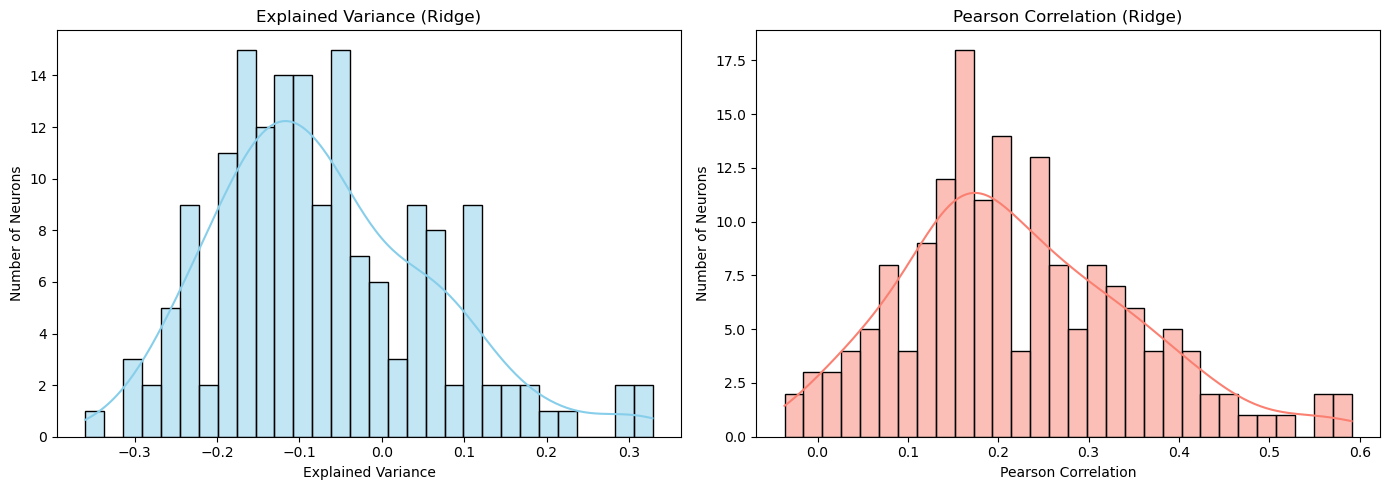

Explained Variance (Linear): -0.0704
Mean Pearson Correlation (Linear): 0.2211


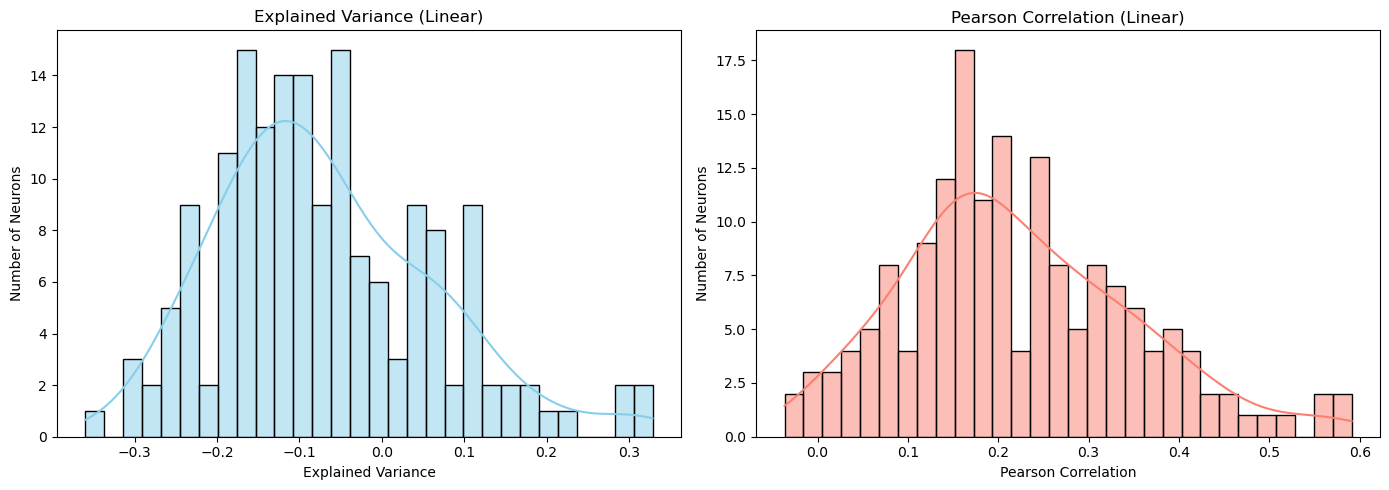

In [26]:
from sklearn.decomposition import PCA

def compute_PCA(data_train, data_val,  n_components=1000):
    pca = PCA(n_components=n_components, svd_solver='auto')
    pca.fit(data_train)
    return pca.transform(data_train), pca.transform(data_val)

predictions_pca = {}

X_train_pca,X_val_pca = compute_PCA(X_train_std, X_val_std)


ridge_pca = Ridge(alpha= 0.1, solver='auto')
ridge_pca.fit(X_train_pca, Y_train)
predictions_pca["Ridge"] = ridge_pca.predict(X_val_pca)

linear_pca = LinearRegression()
linear_pca.fit(X_train_pca, Y_train)
predictions_pca["Linear"] = linear_pca.predict(X_val_pca)


for i, (Y_pred, model_name) in enumerate(zip(predictions_pca.values(), predictions_pca.keys())):
    plot_performance_metrics(Y_pred, model_name)



##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

<span style="color:orange">

**K-fold CV to find best num PC to keep and L2 constrain**

In [27]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


X = X_train_std 
y = Y_train      
labels = np.vstack(df_train['object_label']).flatten()  


n_samples = X.shape[0]  
min_pct = 0.01
max_pca_dim = n_samples  
# pca_dims = np.arange(10, max_pca_dim + 1, step=250)
#pca_dims = [100, 500, 1000]
pca_dims = [1000] 
alphas = np.logspace(-4, 4, num=10) 



cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

best_score = -np.inf
best_params = {}
results = []

print("Starting CV")
for n_comp in tqdm(pca_dims, desc="PCA comp"):
    pca = PCA(n_components=n_comp)
    X_pca_full = pca.fit_transform(X)
    #tqdm.write(f"\n Best so far: {best_params}, explained var : {best_score}")
    for alpha in alphas:
        fold_scores = []

        for train_idx, val_idx in cv.split(X_pca_full, labels):
            X_tr, X_val = X_pca_full[train_idx], X_pca_full[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]

            model = Ridge(alpha=alpha)
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)

            evs = explained_variance_score(y_val, y_pred, multioutput='uniform_average')
            fold_scores.append(evs)

        mean_evs = np.mean(fold_scores)
        results.append({
            'n_components': n_comp,
            'alpha': alpha,
            'mean_explained_variance': mean_evs,   
            
        })

        if mean_evs > best_score:
            best_score = mean_evs
            best_params = {'n_components': n_comp, 'alpha': alpha}

        #tqdm.write(f"PCA={n_comp} | alpha={alpha:.3f} , mean Explained Variance={mean_evs:.4f}")


print("\n Best parameters (by explained variance):")
print(f"    PCA components: {best_params['n_components']}")
print(f"    Ridge alpha:    {best_params['alpha']}")
print(f"    Mean Explained Variance:  {best_score:.4f}")


Starting CV


PCA comp:   0%|          | 0/1 [00:00<?, ?it/s]

PCA comp: 100%|██████████| 1/1 [01:06<00:00, 66.67s/it]


 Best parameters (by explained variance):
    PCA components: 1000
    Ridge alpha:    10000.0
    Mean Explained Variance:  -0.2014


<span style = "color:orange">

**Fitting with the best found parameters**

Explained Variance (Ridge with PCA): -0.0004
Mean Pearson Correlation (Ridge with PCA): 0.2372


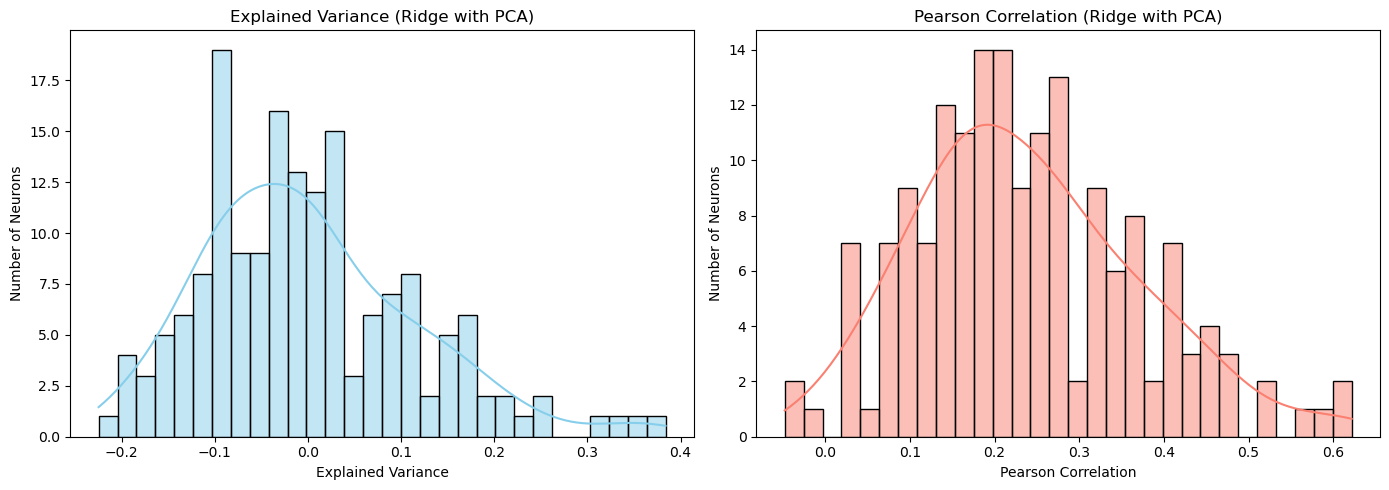

In [28]:
# n_pc = best_params['n_components']
alpha = best_params['alpha']
# pca = PCA(n_components=n_pc)
X_train_pca,X_val_pca = compute_PCA(X_train_std, X_val_std)
model = Ridge(alpha=alpha)
model.fit(X_train_pca, Y_train)
Y_pred = model.predict(X_val_pca)
plot_performance_metrics(Y_pred, "Ridge with PCA",)

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?

- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?

<span style = "color:red">

**TO DO**
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [ ]:
stimulus_train.shape

(2592, 3, 224, 224)

In [29]:
import torch
from torchvision.models import resnet50
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print("Using device:", device)

resnet = resnet50(pretrained=True)
resnet.eval()  # Mode évaluation


return_nodes = {
    'conv1': 'conv1',
    'layer1': 'layer1',
    'layer2': 'layer2',
    'layer3': 'layer3',
    'layer4': 'layer4',
    'avgpool': 'avgpool'
}
feature_extractor = create_feature_extractor(resnet, return_nodes=return_nodes).to(device)



# The normalization done on training data set used to train the ResNet model
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



imgs_tensor = torch.stack([
    transform(np.transpose(img, (1, 2, 0)).astype(np.float32) / 255.) 
    for img in stimulus_train])
dataset = TensorDataset(imgs_tensor)
loader = DataLoader(dataset, batch_size=8, shuffle=False)


imgs_val_tensor = torch.stack([
    transform(np.transpose(img, (1, 2, 0)).astype(np.float32) / 255.) 
    for img in stimulus_val
])
val_dataset = TensorDataset(imgs_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)




Using device: cuda


c:\Users\mathi\.conda\envs\brain_like\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mathi\.conda\envs\brain_like\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<span style = "color:red">

## **Encore a mettre au propre !!**


Processing layer: conv1
Layer conv1 | VAL EV: 0.0599 | mean Pearson: 0.2680


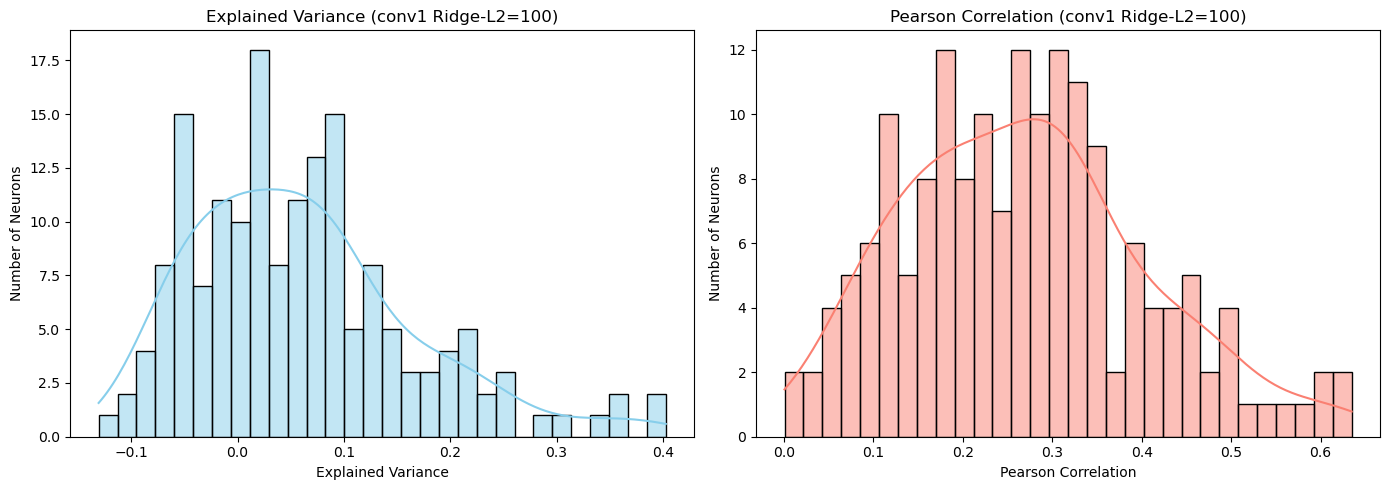


Processing layer: layer1
Layer layer1 | VAL EV: 0.1674 | mean Pearson: 0.4196


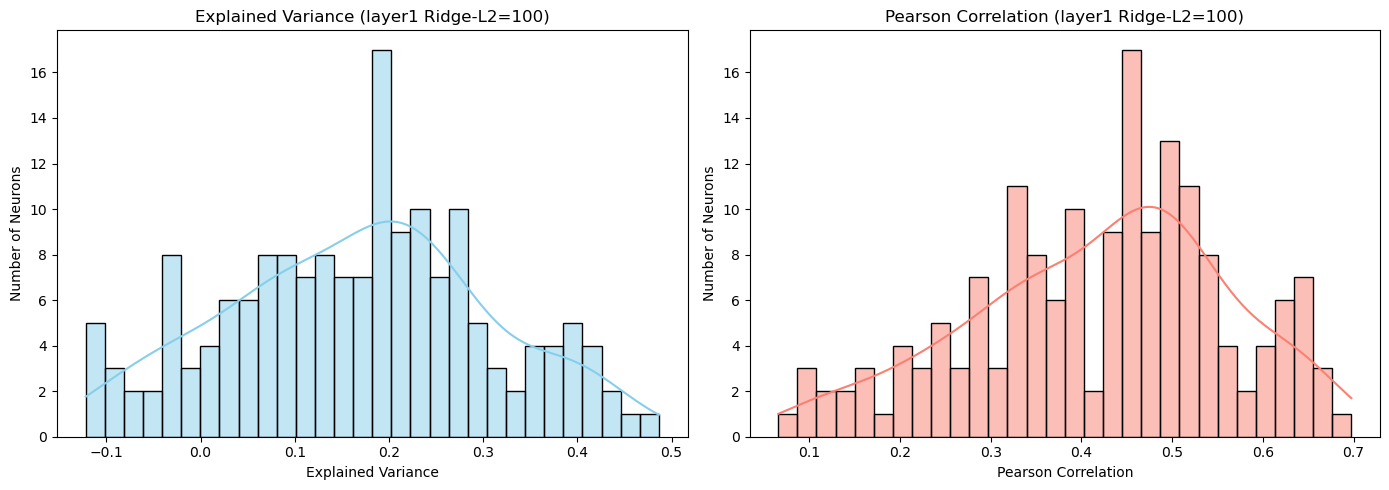


Processing layer: layer2
Layer layer2 | VAL EV: 0.2250 | mean Pearson: 0.4805


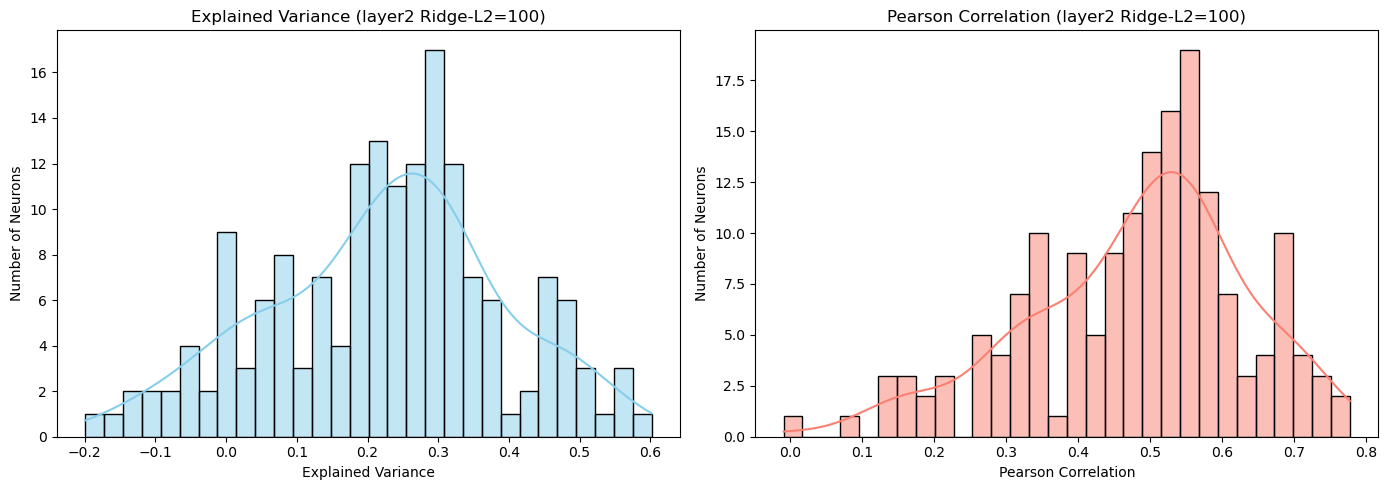


Processing layer: layer3
Layer layer3 | VAL EV: 0.3181 | mean Pearson: 0.5538


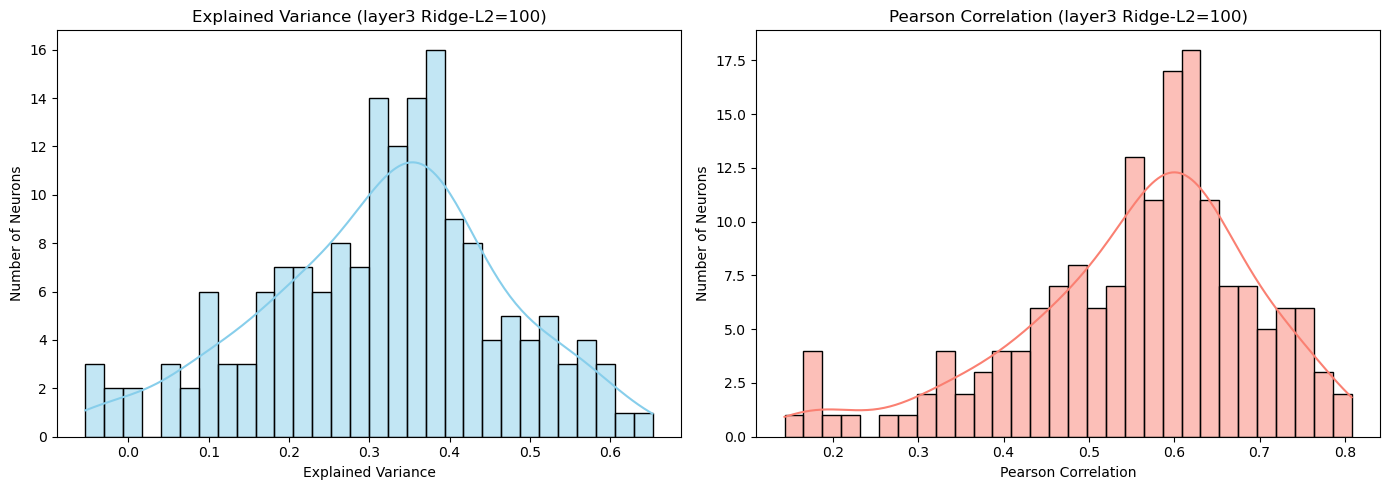


Processing layer: layer4
Layer layer4 | VAL EV: 0.2382 | mean Pearson: 0.5032


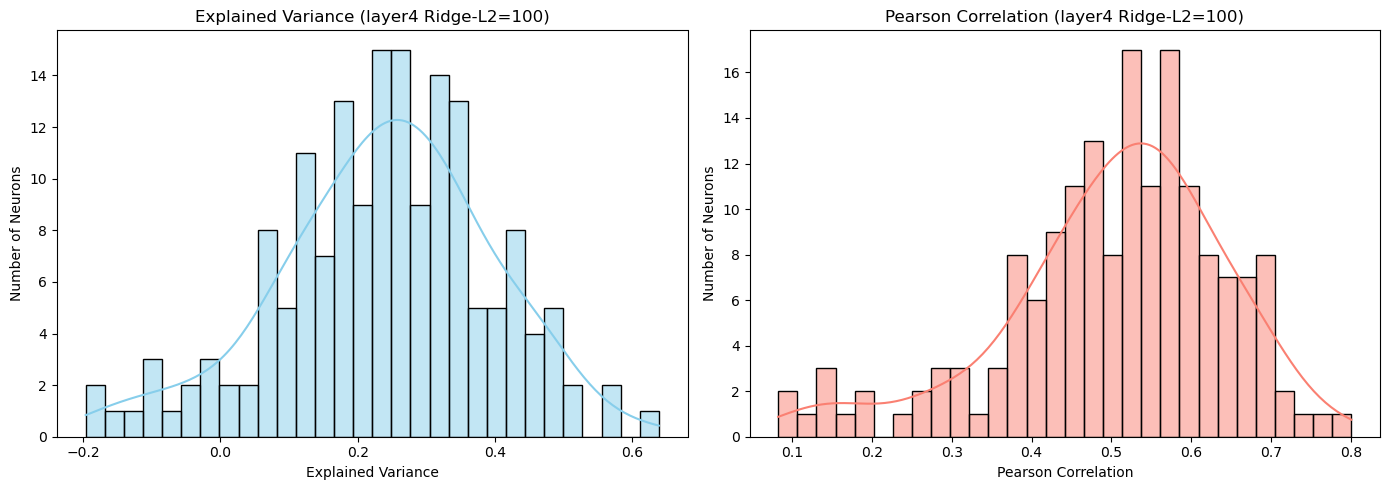


Processing layer: avgpool
Layer avgpool | VAL EV: 0.1954 | mean Pearson: 0.4377


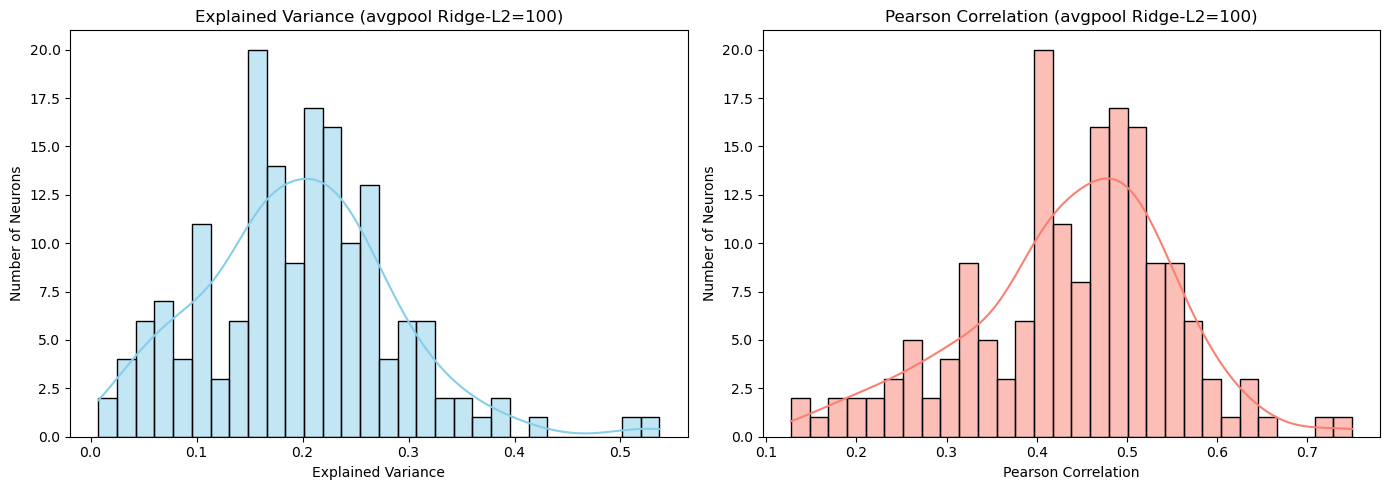

In [30]:

explained_variances = {}
pearson_scores = {}
predictions = {}

for layer_name in return_nodes.values():
    print(f"\nProcessing layer: {layer_name}")
    activations_train = []
    with torch.no_grad():
        for batch in loader:
            imgs = batch[0].to(device)
            feats = feature_extractor(imgs)
            act = feats[layer_name].view(imgs.size(0), -1)
            activations_train.append(act.cpu().numpy())
    X_train = np.vstack(activations_train)

    activations_val = []
    
    with torch.no_grad():
        for batch in val_loader:
            imgs = batch[0].to(device)
            feats = feature_extractor(imgs)
            act = feats[layer_name].view(imgs.size(0), -1)
            activations_val.append(act.cpu().numpy())
    X_val = np.vstack(activations_val)

    if X_train.shape[1] < 1000:
        print(f"Not enough components for PCA, using original activations")
        X_pca_train = X_train
        X_pca_val = X_val
    else:
        pca = PCA(n_components=1000)
        X_pca_train = pca.fit_transform(X_train)
        X_pca_val = pca.transform(X_val) 

    alpha = 100
    model = Ridge(alpha=alpha)
    model.fit(X_pca_train, spikes_train)

    Y_pred_val = model.predict(X_pca_val)
    predictions[layer_name] = Y_pred_val  

    ev = explained_variance_score(spikes_val, Y_pred_val, multioutput='uniform_average')
    pearson_corrs = compute_pearson_per_neuron(spikes_val, Y_pred_val)
    mean_pearson = np.mean(pearson_corrs)

    explained_variances[layer_name] = ev
    pearson_scores[layer_name] = mean_pearson

    print(f"Layer {layer_name} | VAL EV: {ev:.4f} | mean Pearson: {mean_pearson:.4f}")
    
    plot_performance_metrics(Y_pred_val, layer_name + f" Ridge-L2={alpha}", verbose=False)

    


C:\Users\mathi\AppData\Local\Temp\ipykernel_33268\261025559.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([evs_by_layer[layer] for layer in layer_names], labels=layer_names)
C:\Users\mathi\AppData\Local\Temp\ipykernel_33268\261025559.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([pearsons_by_layer[layer] for layer in layer_names], labels=layer_names)


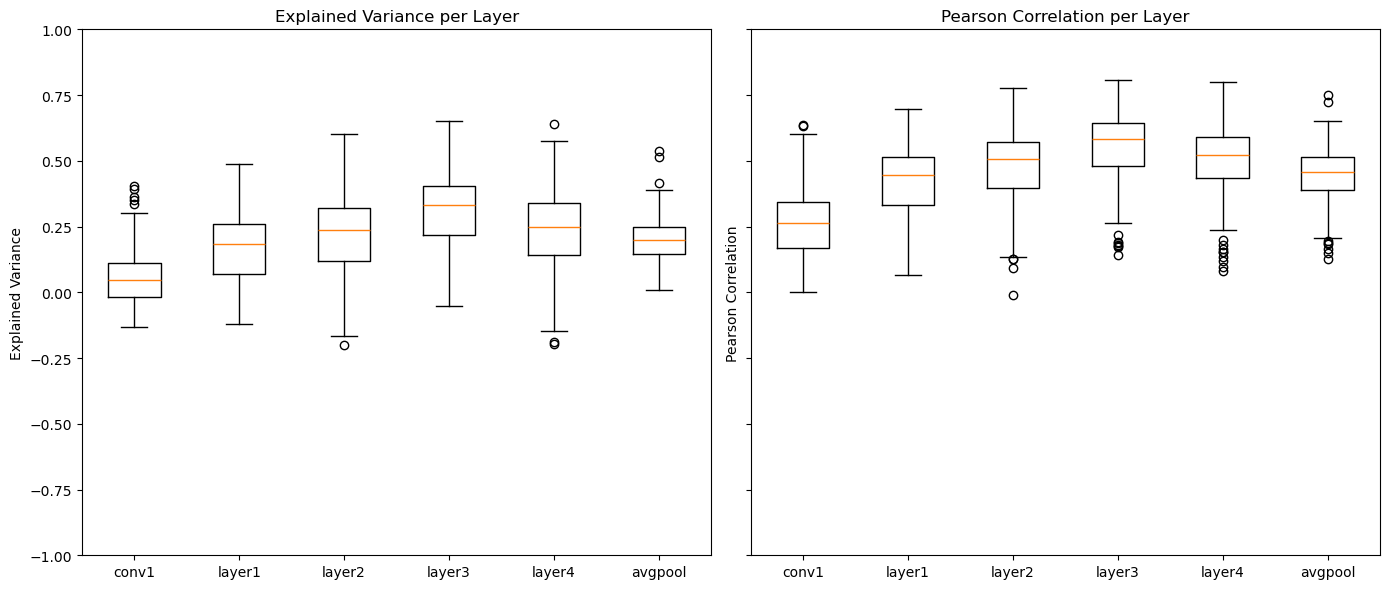

In [33]:
def compute_pearson_per_neuron(y_true, y_pred):
    corrs = []
    for i in range(y_true.shape[1]):
        corr = np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1]
        corrs.append(corr)
    return np.array(corrs)

evs_by_layer = {}
pearsons_by_layer = {}
layer_names = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

for layer in layer_names:
    y_pred = predictions[layer]
    evs = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')
    pearsons = compute_pearson_per_neuron(spikes_val, y_pred)
    evs_by_layer[layer] = evs
    pearsons_by_layer[layer] = pearsons

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].boxplot([evs_by_layer[layer] for layer in layer_names], labels=layer_names)
axes[0].set_title('Explained Variance per Layer')
axes[0].set_ylabel('Explained Variance')
axes[0].set_ylim(-1, 1)

axes[1].boxplot([pearsons_by_layer[layer] for layer in layer_names], labels=layer_names)
axes[1].set_title('Pearson Correlation per Layer')
axes[1].set_ylabel('Pearson Correlation')
axes[1].set_ylim(-1, 1)

plt.tight_layout()
plt.show()
